# Checking pixel misassignment between optimal APD and EBSD data

In [1]:
# SETUP:

# reloading modules if needed
from importlib import reload

# first import the whole package
import PyAPD

# then load all the functions in the .py files in the .../PyAPD/ directory:
from PyAPD import *

import copy

torch.set_printoptions(precision=10) # show more digits

device = "cuda" if torch.cuda.is_available() else "cpu"
dt = torch.float64
torch.set_default_dtype(dt)

[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode


In [2]:
# Load the grain file:

file = "../../../../data/2D_Tata_Steel_paper_example/sample_lc_steel_grain_file_final.txt"
seed_id = (0,1)
volumes_id = (5)
orientation_id = (2,3,4)

X, A, TV, EBSD = load_setup_from_EBSD_data_2D(file = file,
                                             seed_id = seed_id,
                                             volumes_id = volumes_id,
                                             orientation_id = orientation_id,
                                             normalise_matrices = True,
                                             angle_in_degrees = False,
                                             device = device,
                                             dt = dt)
X = X.to(device,dtype=dt)
A = A.to(device,dtype=dt)
TV = TV.to(device,dtype=dt)
N, D = X.shape

In [3]:
# Manually enter the correct domain size:
dom_x = [-999.02675,0.49975]
dom_y = [-901.0003,0.5003]
domain = torch.tensor([dom_x,dom_y])

In [4]:
# Compute total area and show largest and smallest grain:
total_area = TV.sum()
print("Largest grain: ", torch.max(TV).cpu().numpy(), "Smallest grain: ",torch.min(TV).cpu().numpy())

Largest grain:  2073.79661128761 Smallest grain:  11.000898081641


In [5]:
# Construct an APD system:
apd1 = apd_system(D=2,
                  domain = domain,
                  X = X,
                  As = A,
                  heuristic_W = True, # the default set of weights is the heuristic guess
                  target_masses = TV/total_area,
                  dt = torch.float64,
                  device = device,
                  pixel_size_prefactor = 1.0,
                  error_tolerance = 0.01
                  )

In [6]:
# Check number of grains
apd1.N

4587

In [7]:
# Check pixel parameters
apd1.pixel_params

(2863, 2863)

In [8]:
# Compute domain length ratio for plots
len_x = dom_x[1] - dom_x[0]
len_y = dom_y[1] - dom_y[0]

ratio = len_x / len_y

In [9]:
# Save heuristic guess
W_heuristic = copy.deepcopy(apd1.W)

In [10]:
# Plot the APD generated by the heuristic guess first:
img = apd1.assemble_apd(color_by = EBSD[:,-3:])
img2 = img.reshape(apd1.pixel_params + (3,)).transpose(0,1).cpu()

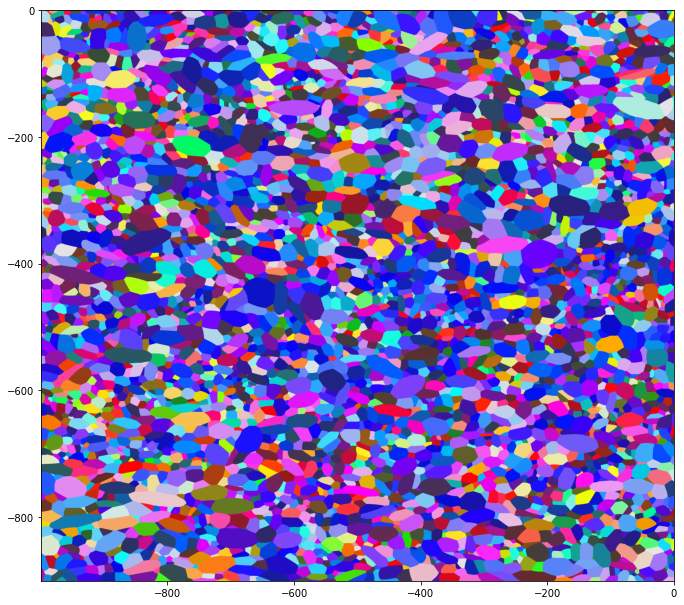

In [11]:
fig, (ax1) = plt.subplots(1,1)
fig.set_size_inches(ratio*10.5, 10.5, forward=True)
ax1.imshow(img2, origin='upper', extent = torch.flatten( apd1.domain ).tolist())

In [12]:
# Check that error is still huge
Dg, error = apd1.check_optimality(return_gradient_and_error=True)

Precision loss detected!
Percentage error =  380.39910107162774


In [13]:
# Solve the OT problem to get optimal weights:
apd1.optimality = False
apd1.check_optimality()
apd1.find_optimal_W()

Precision loss detected!
Percentage error =  380.39910107162774
Solver tolerance is with respect to each grain separately.
Smallest tol:  tensor(0.1099153069, device='cuda:0')
Optimality condition successfully overwritten.
Optimization terminated successfully.
         Current function value: -64128011.527938
         Iterations: 240
         Function evaluations: 401
It took 50.59414267539978 seconds to find optimal W.


In [14]:
# Check optimality
apd1.check_optimality()

The APD is optimal!
Percentage error =  0.9864448173073024


In [15]:
# Save optimal weights
W_optimal = copy.deepcopy(apd1.W)

In [12]:
# Create a set of pixels to match the pixelated EBSD data:
i = 0
grid_x = torch.linspace(apd1.domain[i,0] + 0.9995/2, apd1.domain[i,1] - 0.9995/2, 1000)

i = 1
grid_y = torch.linspace(apd1.domain[i,0] + 1.0006/2, apd1.domain[i,1] - 1.0006/2, 901)

mesh1 = torch.meshgrid((grid_x,grid_y), indexing="ij") if apd1.D == 2 else torch.meshgrid((grid_x,grid_y,grid_z), indexing="ij")
pixels1 = torch.stack(mesh1, dim=-1).to(device=apd1.device,dtype=apd1.dt)
pixels1b = pixels1.reshape(-1, apd1.D)
pixels = pixels1b
PS = torch.ones(pixels.shape[0])

In [13]:
# Check that we get the correct number of pixels
len(pixels)

901000

In [14]:
# Pass it to the apd system:
apd1.Y = pixels.to(device=apd1.device, dtype=apd1.dt)
apd1.PS = PS.to(device=apd1.device, dtype=apd1.dt)
apd1.y = LazyTensor(apd1.Y.view(1,apd1.Y.shape[0],apd1.D))

In [19]:
# Check how many pixels are assisgned to different grains
# when comparing the optimal W and the heuristic W:
apd1.set_W(W = W_optimal)
img_optimal = copy.deepcopy(apd1.assemble_apd())
apd1.set_W(W = W_heuristic)
img_heuristic = copy.deepcopy(apd1.assemble_apd())

diff_opt_heu = sum(torch.abs(img_heuristic - img_optimal) > 0.5)

diff_opt_heu / img_optimal.shape[0]

tensor(0.0437380688, device='cuda:0')

In [20]:
# Assemble our pixelated data: positions of pixels and grain assignment:
My_pixel_data = torch.cat((apd1.Y,img_optimal[...,None]), 1)

In [15]:
# Load EBSD pixelated data: positions of pixels and grain assignment (from MTEX):
file = "../../../../data/2D_Tata_Steel_paper_example/grainIDs_final.txt"
EBSD_pixel_data = torch.from_numpy(np.loadtxt(file)).to(device=apd1.device, dtype=apd1.dt)

In [16]:
len(EBSD_pixel_data)

896361

In [22]:
# Pixels in our data and the EBSD data are not ordered in the same way
# so find a correspondence between the same pixels between two data sets
II = [(torch.norm(EBSD_pixel_data[:,0:2][i] - My_pixel_data[:,0:2],dim=1) < 0.1).nonzero().item() for i in range(EBSD_pixel_data.shape[0]) ]

In [23]:
# Check pixel mismatch between EBSD data and the optimal APD:
mismatch_optimal = img_optimal[II] - EBSD_pixel_data[:,2] + 1
diff_optimal_ebsd = sum(torch.abs(mismatch_optimal) > 0.5)
diff_optimal_ebsd /EBSD_pixel_data.shape[0]

tensor(0.1046498007, device='cuda:0')

In [24]:
# Check pixel mismatch between EBSD data and the heuristic APD:
mismatch_heuristic = img_heuristic[II] - EBSD_pixel_data[:,2] + 1
diff_heuristic_ebsd = sum(torch.abs(mismatch_heuristic) > 0.5)
diff_heuristic_ebsd /EBSD_pixel_data.shape[0]

tensor(0.1016565870, device='cuda:0')

# Creating an EBSD data file to get MTEX to plot nice boundaries

In [17]:
# Load the square pixel MTEX EBSD file:
file = "../../../../data/2D_Tata_Steel_paper_example/sample_lc_steel_sqr.ang"
data = np.loadtxt(file)
data_torch = torch.from_numpy(data).to(device,dtype=dt)

In [18]:
# Load the mean grain orientation file (from MTEX):
file = "../../../../data/2D_Tata_Steel_paper_example/grains_mean_orientation_final.txt" 
crystal_orient_grains = np.loadtxt(file)
crystal_orient_grains = torch.from_numpy(crystal_orient_grains).to(device,dtype=dt)

In [27]:
# The square pixel MTEX EBSD file orients the pixels differently,
# so flip pixel locations via point symmetry around the origin:
data_torch[:,3:5] = - data_torch[:,3:5]

In [19]:
# Check that we have the correct number of pixels
data_torch.shape

torch.Size([901000, 10])

In [29]:
# Createa a new data file to be exported later
data_torch_new = copy.deepcopy(data_torch)

In [30]:
# Pixels in our data and the EBSD data are not ordered in the same way
# so find a correspondence between the same pixels between two data sets
II = [(torch.norm(data_torch[:,3:5][i] - My_pixel_data[:,0:2],dim=1) < 0.1).nonzero().item() for i in range(data_torch.shape[0]) ]

In [31]:
# Set the crystallographic orientation of each pixel 
# to match the mean orientation of the grain it belongs to
data_torch_new[:,0:3] = crystal_orient_grains[img_optimal[II]]

In [32]:
# Export the new EBSD data file to be passed to MTEX for plotting:
data_new = np.array(data_torch_new.cpu())
fmt = '%1.5f', '%1.5f', '%1.5f', '%1.5f', '%1.5f', '%1.1f', '%1.3f', '%d', '%d', '%1.3f'
np.savetxt("ebsd_data_for_MTEX.txt",data_new, fmt=fmt)

In [ ]:
# The final manual step is to make the exported file look like a '.ang' file.
# The resulting file is located in `data/2D_Tata_Steel_paper_example/ebsd_data_for_MTEX.ang`